## Beautiful Demo

Loads training data and shows an example training face

reading csv: 3.9890758991241455
formatting to numpy matrices: 4.046406030654907
picking random data: 0.00816202163696289
Formatting data: 1.621246337890625e-05


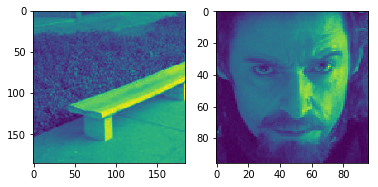

In [9]:
from matplotlib import pyplot as plt
from read_data import training_validation

from time import time
from random import choice

(training_images, training_labels), (test_images, test_labels) = training_validation()

sample_image_positive = choice(training_images)
sample_image_negative = choice(test_images)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample_image_positive)
ax2.imshow(sample_image_negative)
plt.show()



## Example of feature selection used

-13935.0
-36291.0
-3697.0
241881.0
264855.0


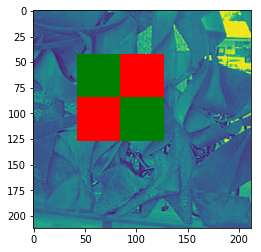

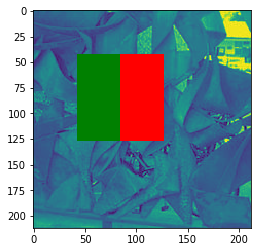

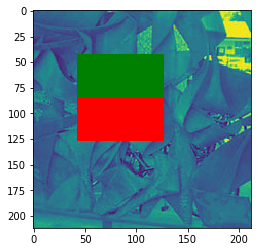

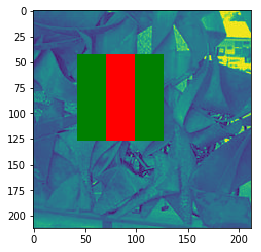

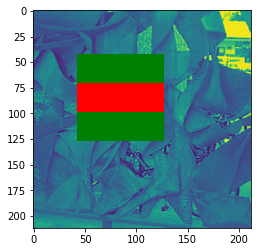

In [2]:
from features import *
from processing import IntegralImage

fsize = FeatureSize(0.2, 0.2, 0.4, 0.4)
ii = IntegralImage(sample_image_positive)
ii.process()

f = Feature(fsize, A)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))


plt.show()

## Example of Feature Generation

In [3]:
from features import *
count = 0
for sz in generate_all_sizes():
    count += 1
print(count)

225


## Format training and test data

The format is adapted for the special ada boosted version, to extract features, therefore to train the normal bayes
we have to transpose the data to get image x features instead of features x images.

In [4]:
import processing
import features
import os
import pickle
from numpy import save, load




outTrain = None
outTest = None

training = None
test = None
IItraining = None
IItest = None
all_features = features.generate_all_features()

if not os.path.isfile("training_feature_matrix.npy"):
    
    print("Stage 1")
    IItraining = processing.bulk_II(training_images)
    IItest = processing.bulk_II(test_images)
    
    outTrain = open('IITraining.pkl', 'wb')
    outTest = open('IITesting.pkl', 'wb')
    pickle.dump(IItraining, outTrain)
    pickle.dump(IItest, outTest)
    outTrain.close()
    outTest.close()
    
    print("Stage 2")
    training = features.get_feature_matrix(IItraining, all_features)
    test = features.get_feature_matrix(IItest, all_features)

    """ _ is same as above. """

    save("training_feature_matrix", training)
    save("test_feature_matrix", test)
else:
    training = load("training_feature_matrix.npy")
    test = load("test_feature_matrix.npy")
    outTrain = open('IITraining.pkl', 'rb')
    outTest = open('IITesting.pkl', 'rb')
    IItraining = pickle.load(outTrain)
    IItest = pickle.load(outTest)
    outTrain.close()
    outTest.close()
    



Generate all features: 0.0009059906005859375


## Display of Integral Image

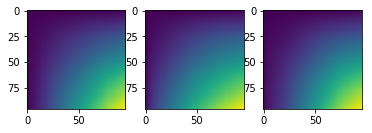

In [5]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(IItraining[0].ii)
ax2.imshow(IItraining[200].ii)
ax3.imshow(IItraining[400].ii)

plt.show()


## Testing Naive Bayes 

Naive bayes based on Normal distribution

950
Success rate: 0.8221052631578948
False positives 0.16526315789473683
False negatives 0.01263157894736842


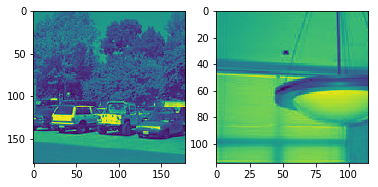

In [6]:
from naive_bayes import naive_bayes
from numpy import array, save
from sys import stdout

# Bayes is weak when there's to many features.
training_for_bayes = training[500:510].T
test_for_bayes = test[500:510].T


classifier = naive_bayes()
classifier.train(training_for_bayes, training_labels)

correct = 0
total = len(test_for_bayes)
print(total)

false_positive = None
false_negative = None

false_positives = 0
false_negatives = 0 
for index, image in enumerate(test_for_bayes):
    #stdout.write("\r\r\r" + str(index) + str("\r\r\r"))
    
    prediction = classifier.predict(image)
    label = test_labels[index]
    
    false_positives += (prediction == 1 and label == 0)
    false_negatives += (prediction == 0 and label == 1)
    
    if prediction == 1 and label == 0:
        false_positive = test_images[index]
    
    if prediction == 0 and label == 0:
        false_negative = test_images[index]
        
    correct += 1 if classifier.predict(image) == test_labels[index] else 0
    

fig, (fp, fn) = plt.subplots(1, 2)

fp.imshow(false_positive)
fn.imshow(false_negative)

print("Success rate: {}".format(correct / total))
print("False positives {}".format(false_positives / total))
print("False negatives {}".format(false_negatives / total))

plt.show()

## Example of a single feature boosted classifier

A bunch of these are combined in the cascade

Training boosted classifier with 10 features
950ssifiers left: 0
Success rate: 0.9378947368421052
False positives 0.03263157894736842
False negatives 0.029473684210526315


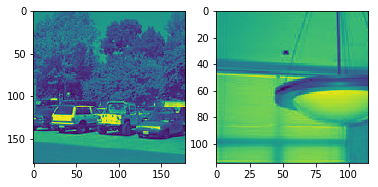

In [7]:
from ada_boost import boosted_classifier

# Constructor takes num of features
classifier = boosted_classifier(10)
classifier.train(training, all_features, training_labels)

correct = 0
total = len(test_for_bayes)
print(total)

false_positive = None
false_negative = None

false_positives = 0
false_negatives = 0 
for index, image in enumerate(IItest):
    #stdout.write("\r\r\r" + str(index) + str("\r\r\r"))
    
    prediction = classifier.predict(image)
    label = test_labels[index]
    
    false_positives += (prediction == 1 and label == 0)
    false_negatives += (prediction == 0 and label == 1)
    
    if prediction == 1 and label == 0:
        false_positive = test_images[index]
    
    if prediction == 0 and label == 0:
        false_negative = test_images[index]
        
    correct += 1 if classifier.predict(image) == test_labels[index] else 0
    

fig, (fp, fn) = plt.subplots(1, 2)

fp.imshow(false_positive)
fn.imshow(false_negative)

print("Success rate: {}".format(correct / total))
print("False positives {}".format(false_positives / total))
print("False negatives {}".format(false_negatives / total))

plt.show()



In [8]:
from cascade import cascade
from numpy import array

c = cascade(0.35, 0.7)
c.train(IItraining, array(training_labels), 0.05)

Starting training
Round we go!! Currently: 1.0  Target is:  0.05
Generate all features: 0.0010499954223632812
get feature matrix: 2.3792309761047363
Generating classifiers with 1 features
Feature matrix shape (1125, 189)
Training boosted classifier with 1 features


KeyboardInterrupt: 